In [70]:
# %pip install numpy
# %pip install pandas
# %pip install opencv-python
# %pip install matplotlib
# %pip install plotly
# %pip install tensorflow
# %pip install setuptools
# %pip install keras
# %pip install scikit-learn
# %pip install mtcnn
# %pip install keras-facenet
# %pip install wandb

# Libraries

# Main
import os
import glob
import gc
import numpy as np
import pandas as pd
import cv2
import time
import random
import datetime

import wandb
# from wandb.keras import WandbCallback

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Deep Learning
import tensorflow as tf
from keras.models import load_model, Model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.preprocessing import image as k_image
from keras_facenet import FaceNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Input, Lambda, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.applications import MobileNetV2, ResNet50, InceptionV3, VGG16
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.callbacks import ReduceLROnPlateau

import ssl

ssl._create_default_https_context = ssl._create_unverified_context

# Warning
import warnings
warnings.filterwarnings("ignore")


In [71]:
class CFG:
    batch_size = 8
    img_height = 160
    img_width = 160
    epoch = 50 # TODO: czy jest sens robic mniej lub więcej epoch

    @classmethod
    def set_epoch(cls, new_epoch):
        cls.epoch = new_epoch

# define global constants
NUMBER_OF_CLASSES = 50

In [72]:
def create_dataframe(dataset_path):
    list_path = []
    labels = []

    identities = os.listdir(dataset_path)
    for identity in identities:
        identity_path = os.path.join(dataset_path, identity, "*")
        image_files = glob.glob(identity_path)

        identity_label = [identity] * len(image_files)

        list_path.extend(image_files)
        labels.extend(identity_label)

    data = pd.DataFrame({
        "image_path": list_path,
        "identity": labels
    })

    return data


In [73]:
dataset_path = "dataset/P1-72-50"
data = create_dataframe(dataset_path)

def write_to_output(*args):
    with open("results/output.txt", "a") as f:
        output_string = ' '.join(str(arg) for arg in args)
        print(output_string, file=f)


                   image_path identity
0  dataset/P1-72-50/32/63.png       32
1  dataset/P1-72-50/32/62.png       32
2  dataset/P1-72-50/32/60.png       32
3  dataset/P1-72-50/32/48.png       32
4  dataset/P1-72-50/32/49.png       32
(3600, 2)


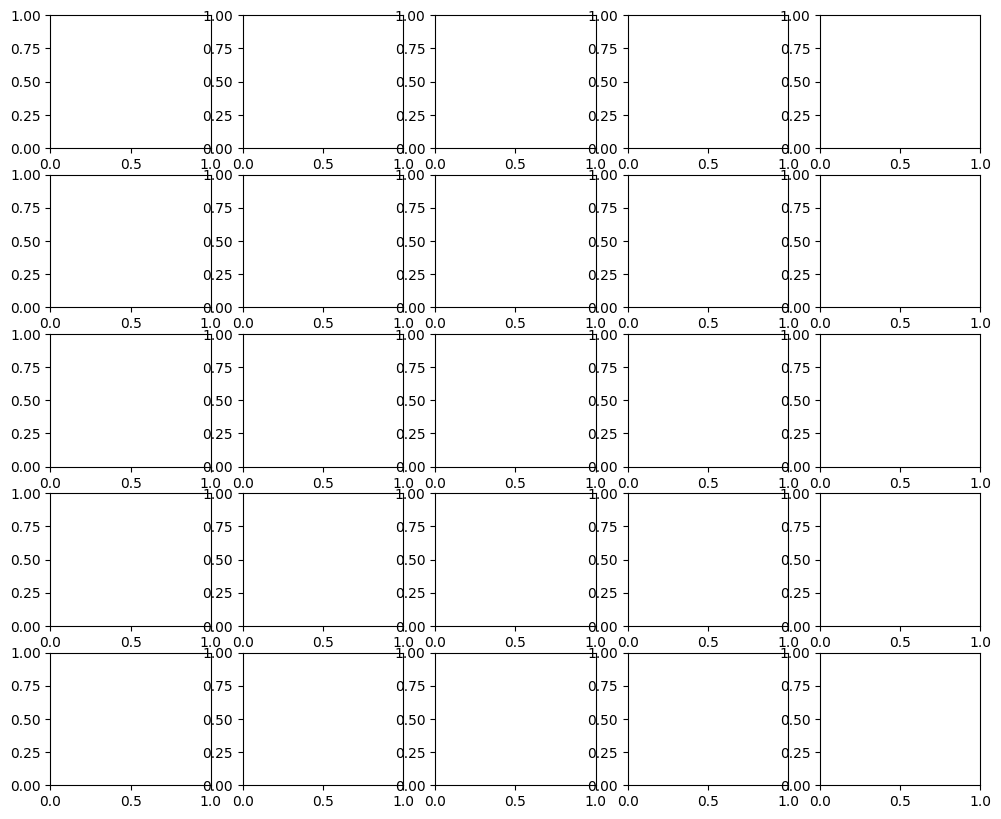

In [74]:
fig, axs = plt.subplots(5, 5, figsize=(12, 10))


print(data.head())
print(data.shape)

# Plot Images. Show 5 different persons by identity
# for i, ax in enumerate(axs.flat):
#     identity = data["identity"].unique()[i]
#     image_path = data[data["identity"] == identity]["image_path"].values[0]
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     ax.imshow(image)
#     ax.axis("off")
#     ax.set_title(identity)



In [75]:
def split_data(data, test_size, random_state=2023):
    X_train, X_test, y_train, y_test = train_test_split(
        data["image_path"], data["identity"],
        test_size=test_size,
        random_state=random_state,
        shuffle=True,
        stratify=data["identity"]
    )
    data_train = pd.DataFrame({
        "image_path": X_train,
        "identity": y_train
    })
    data_test = pd.DataFrame({
        "image_path": X_test,
        "identity": y_test
    })

    print(data_test["identity"].value_counts())
    print(data_train["identity"].value_counts())

    return data_train, data_test


def split_data_random_size(data, min_test_size=0.1, max_test_size=0.9, random_state=2023):
    unique_identities = data["identity"].unique()
    data_train = pd.DataFrame(columns=["image_path", "identity"])
    data_test = pd.DataFrame(columns=["image_path", "identity"])

    for identity in unique_identities:
        identity_data = data[data["identity"] == identity]
        test_size = random.uniform(min_test_size, max_test_size)

        X_train, X_test, y_train, y_test = train_test_split(
            identity_data["image_path"],
            identity_data["identity"],
            test_size=test_size,
            random_state=random_state,
            shuffle=True
        )

        data_train = pd.concat([data_train, pd.DataFrame({"image_path": X_train, "identity": y_train})], ignore_index=True)
        data_test = pd.concat([data_test, pd.DataFrame({"image_path": X_test, "identity": y_test})], ignore_index=True)
    # use write_to_output to show summory of how big test size for equal identity
    write_to_output(data_test["identity"].value_counts())
    write_to_output(data_train["identity"].value_counts())

    print(data_test["identity"].value_counts())
    print(data_train["identity"].value_counts())
    return data_train, data_test

In [76]:
def create_model(num_classes, model_name="MobileNetV2"):
    if model_name == "MobileNetV2":
        base_model = MobileNetV2(
            input_shape=(CFG.img_height, CFG.img_width, 3),
            include_top=False,
            weights="imagenet"
        )
    elif model_name == "ResNet50":
        base_model = ResNet50(
            input_shape=(CFG.img_height, CFG.img_width, 3),
            include_top=False,
            weights="imagenet"
        )
    elif model_name == "InceptionV3":
        base_model = InceptionV3(
            input_shape=(CFG.img_height, CFG.img_width, 3),
            include_top=False,
            weights="imagenet"
        )
    elif model_name == "VGG16":
        base_model = VGG16(
            input_shape=(CFG.img_height, CFG.img_width, 3),
            include_top=False,
            weights="imagenet"
        )
    else:
        raise ValueError("Invalid model name. Please choose from 'MobileNetV2', 'ResNet50', 'InceptionV3', or 'VGG16'.")

    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(base_model.input, output)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"]) # mona spróbować AdamW, zamiast categorical_crossentropy użyć triplet loss

    return model

# function to create and return flow_from_dataframe
def create_flow_from_dataframe(data):
    datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_dataframe(
        data,
        x_col="image_path",
        y_col="identity",
        target_size=(CFG.img_height, CFG.img_width),
        batch_size=CFG.batch_size,
        class_mode="categorical"  # Use "categorical" class mode for multiple classes
    )

    return generator

# Function to test the model
def train_and_test_model(model, model_name, data_train, data_test):

    train_generator = create_flow_from_dataframe(data_train)
    test_generator = create_flow_from_dataframe(data_test)

    start_fitting_time = datetime.datetime.now()
    model.fit(train_generator, epochs=CFG.epoch, verbose=1)
    stop_fitting_time = datetime.datetime.now()

    write_to_output("Fitting duration: ", stop_fitting_time - start_fitting_time)


    test_loss, test_accuracy = model.evaluate(test_generator)

    # Write output to file
    write_to_output("Number of epoch: ", CFG.epoch)
    write_to_output("Test Loss: ", test_loss)
    write_to_output("Test Accuracy: ", test_accuracy)
    write_to_output("=========================")





In [77]:
# base params
test_size=0.2
test_sizes = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
data_train, data_test = split_data(data, test_size)
models = ["VGG16", "InceptionV3", "ResNet50", "MobileNetV2"]
# models = ["MobileNetV2"]



identity
15    15
38    15
24    15
31    15
49    15
37    15
48    15
34    15
13    15
11    15
44    15
29    15
6     15
3     15
14    15
30    15
42    15
5     15
39    15
20    15
22    14
36    14
27    14
32    14
43    14
9     14
18    14
7     14
0     14
35    14
19    14
25    14
21    14
4     14
1     14
17    14
26    14
10    14
16    14
41    14
8     14
12    14
45    14
28    14
23    14
46    14
47    14
2     14
40    14
33    14
Name: count, dtype: int64
identity
9     58
4     58
18    58
27    58
0     58
16    58
26    58
36    58
47    58
21    58
19    58
32    58
10    58
43    58
33    58
7     58
22    58
46    58
35    58
2     58
40    58
17    58
41    58
23    58
25    58
1     58
28    58
12    58
45    58
8     58
5     57
24    57
13    57
6     57
44    57
15    57
11    57
37    57
29    57
38    57
14    57
31    57
49    57
42    57
3     57
48    57
39    57
30    57
20    57
34    57
Name: count, dtype: int64


In [78]:
write_to_output("1. Check number of \"epoch\" needed for good presition")
write_to_output("test_size: ", test_size)
write_to_output("=========================")

for model_name in models:
    write_to_output("Model name: ", model_name)

    for i in range(10, 0, -1):
        print(i)
        CFG.set_epoch(i)
        model = create_model(NUMBER_OF_CLASSES, model_name)
        train_and_test_model(model, model_name, data_train, data_test)

10
Found 2880 validated image filenames belonging to 50 classes.
Found 720 validated image filenames belonging to 50 classes.
Epoch 1/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 149s 410ms/step - accuracy: 0.0695 - loss: 3.7919
Epoch 2/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 136s 379ms/step - accuracy: 0.4589 - loss: 2.3491
Epoch 3/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 135s 375ms/step - accuracy: 0.7534 - loss: 1.2960
Epoch 4/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 135s 375ms/step - accuracy: 0.8575 - loss: 0.8016
Epoch 5/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 142s 394ms/step - accuracy: 0.9289 - loss: 0.5212
Epoch 6/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 136s 377ms/step - accuracy: 0.9630 - loss: 0.3603
Epoch 7/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 136s 378ms/step - accuracy: 0.9754 - loss: 0.2558
Epoch 8/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 138s 382ms/step - accuracy: 0.9853 - loss: 0.1855
Epoch 9/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 138s 384ms/step - accuracy: 0.9932 - loss: 0.1186
Epoch 10/10
360/360 ━━━━━━━━━━━━━━━━━━━━ 138s 383ms/step - accur

In [79]:
CFG.set_epoch(5)
write_to_output("")
write_to_output("2. Check how many photos of one persone needed. Using 3 epoch")

for model_name in models:
    write_to_output("Model name: ", model_name)
    for test_size in test_sizes:
        data_train, data_test = split_data(data, test_size)
        model = create_model(NUMBER_OF_CLASSES, model_name)
        write_to_output("Test size: ", test_size)
        train_and_test_model(model, model_name, data_train, data_test)


identity
33    65
9     65
34    65
27    65
21    65
1     65
48    65
22    65
11    65
14    65
15    65
49    65
32    65
20    65
30    65
37    65
35    65
25    65
41    65
39    65
19    65
8     65
13    65
38    65
45    65
42    65
3     65
12    65
31    65
23    65
16    65
6     65
44    65
0     65
5     65
24    65
36    65
7     65
46    65
29    65
4     64
17    64
47    64
28    64
43    64
26    64
40    64
10    64
2     64
18    64
Name: count, dtype: int64
identity
10    8
18    8
26    8
47    8
43    8
40    8
2     8
4     8
28    8
17    8
38    7
21    7
13    7
11    7
25    7
45    7
24    7
31    7
46    7
37    7
29    7
19    7
3     7
6     7
34    7
14    7
0     7
49    7
42    7
7     7
16    7
33    7
48    7
30    7
36    7
27    7
35    7
32    7
12    7
39    7
15    7
8     7
20    7
41    7
9     7
1     7
22    7
44    7
5     7
23    7
Name: count, dtype: int64
Found 360 validated image filenames belonging to 50 classes.
Found 3240 validate

In [80]:
CFG.set_epoch(1)
write_to_output("")
write_to_output("3. Fitting time")

for model_name in models:
    write_to_output("Model name: ", model_name)
    for test_size in test_sizes:
        data_train, data_test = split_data(data, test_size)
        model = create_model(NUMBER_OF_CLASSES, model_name)
        write_to_output("Test size: ", test_size)
        train_and_test_model(model, model_name, data_train, data_test)

identity
33    65
9     65
34    65
27    65
21    65
1     65
48    65
22    65
11    65
14    65
15    65
49    65
32    65
20    65
30    65
37    65
35    65
25    65
41    65
39    65
19    65
8     65
13    65
38    65
45    65
42    65
3     65
12    65
31    65
23    65
16    65
6     65
44    65
0     65
5     65
24    65
36    65
7     65
46    65
29    65
4     64
17    64
47    64
28    64
43    64
26    64
40    64
10    64
2     64
18    64
Name: count, dtype: int64
identity
10    8
18    8
26    8
47    8
43    8
40    8
2     8
4     8
28    8
17    8
38    7
21    7
13    7
11    7
25    7
45    7
24    7
31    7
46    7
37    7
29    7
19    7
3     7
6     7
34    7
14    7
0     7
49    7
42    7
7     7
16    7
33    7
48    7
30    7
36    7
27    7
35    7
32    7
12    7
39    7
15    7
8     7
20    7
41    7
9     7
1     7
22    7
44    7
5     7
23    7
Name: count, dtype: int64
Found 360 validated image filenames belonging to 50 classes.
Found 3240 validate

KeyboardInterrupt: 

In [81]:
CFG.set_epoch(5)
write_to_output("")
write_to_output("4. Niezbalansowane dane")
data_train_base, data_test_base = split_data_random_size(data)

for model_name in models:
    write_to_output("Model name: ", model_name)
    # data_train, data_test = split_data_random_size(data)
    data_train = data_train_base
    data_test = data_test_base

    model = create_model(NUMBER_OF_CLASSES, model_name)
    train_and_test_model(model, model_name, data_train, data_test)



identity
39    65
12    62
11    61
17    60
0     60
5     59
18    58
20    55
8     54
25    53
26    53
32    52
43    52
19    44
4     44
14    42
23    41
44    41
27    41
36    40
2     39
37    39
22    36
35    36
40    36
33    33
3     32
38    32
24    30
42    27
16    26
1     24
7     24
15    24
6     23
41    23
47    23
31    21
48    17
13    16
46    15
30    15
45    13
9     13
29    12
10    12
28    11
49    10
34     9
21     8
Name: count, dtype: int64
identity
21    64
34    63
49    62
28    61
10    60
29    60
9     59
45    59
46    57
30    57
13    56
48    55
31    51
47    49
6     49
41    49
15    48
7     48
1     48
16    46
42    45
24    42
38    40
3     40
33    39
40    36
35    36
22    36
37    33
2     33
36    32
23    31
27    31
44    31
14    30
4     28
19    28
32    20
43    20
26    19
25    19
8     18
20    17
18    14
5     13
17    12
0     12
11    11
12    10
39     7
Name: count, dtype: int64
Found 1884 validated image fil

In [85]:
# Создание эмбеддинг-модели
def embedding_model(input_shape, model_name="MobileNetV2"):
    if model_name == "MobileNetV2":
        base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == "ResNet50":
        base_model = ResNet50(input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == "InceptionV3":
        base_model = InceptionV3(input_shape=input_shape, include_top=False, weights="imagenet")
    elif model_name == "VGG16":
        base_model = VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    else:
        raise ValueError("Invalid model name. Please choose from 'MobileNetV2', 'ResNet50', 'InceptionV3', or 'VGG16'.")

    for layer in base_model.layers:
        layer.trainable = False

    # x = Flatten()(base_model.output)
    # x = Dense(512, activation="relu")(x)
    # x = Dense(128, activation="relu")(x)
    # x = Dense(64, activation="relu")(x)
    # embedding_output = Dense(32, activation="relu")(x)

    x = Flatten()(base_model.output)
    x = Dense(512, activation="relu")(x)
    x = Dense(128, activation="relu")(x)
    embedding_output = Dense(50, activation="relu")(x)

    model = Model(base_model.input, embedding_output)
    return model

def create_siamese_network(input_shape, model_name="MobileNetV2"):
    embedding_net = embedding_model(input_shape, model_name)

    input_anchor = Input(shape=input_shape)
    input_positive = Input(shape=input_shape)
    input_negative = Input(shape=input_shape)

    embedding_anchor = embedding_net(input_anchor)
    embedding_positive = embedding_net(input_positive)
    embedding_negative = embedding_net(input_negative)

    merged_output = Lambda(lambda embeddings: K.stack(embeddings, axis=1))([embedding_anchor, embedding_positive, embedding_negative])

    siamese_network = Model(inputs=[input_anchor, input_positive, input_negative], outputs=merged_output)
    return siamese_network

# Определение функции потерь Triplet Loss
def triplet_loss(margin=1.0):
    def _triplet_loss(y_true, y_pred):
        anchor, positive, negative = y_pred[:, 0], y_pred[:, 1], y_pred[:, 2]
        pos_dist = K.sum(K.square(anchor - positive), axis=-1)
        neg_dist = K.sum(K.square(anchor - negative), axis=-1)
        loss = K.maximum(pos_dist - neg_dist + margin, 0.0)
        return loss
    return _triplet_loss

# Создание триплетов
def create_triplets(data, num_triplets_per_class=20):
    triplets = []
    unique_classes = data['identity'].unique()  # Получаем уникальные классы (идентификаторы)

    for anchor_class in unique_classes:  # Проходим по каждому классу
        class_data = data[data['identity'] == anchor_class]  # Выбираем все изображения текущего класса
        num_samples = len(class_data)  # Получаем количество изображений в этом классе

        for _ in range(min(num_triplets_per_class, num_samples)):
            # Выбор случайного якорного изображения
            anchor_idx = np.random.choice(class_data.index)  # Случайным образом выбираем индекс изображения из текущего класса
            anchor_image = cv2.imread(class_data['image_path'][anchor_idx])  # Загружаем изображение по выбранному индексу
            #anchor_label = class_data['identity'][anchor_idx]  # Получаем метку класса для выбранного изображения

            # Выбор положительного изображения
            positive_idx = np.random.choice(class_data[class_data.index != anchor_idx].index)  # Случайным образом выбираем индекс другого изображения из текущего класса
            positive_image = cv2.imread(class_data['image_path'][positive_idx])  # Загружаем положительное изображение

            # Выбор отрицательного изображения
            negative_class = np.random.choice(unique_classes[unique_classes != anchor_class])  # Случайным образом выбираем другой класс
            negative_idx = np.random.choice(data[data['identity'] == negative_class].index)  # Случайным образом выбираем индекс изображения из другого класса
            negative_image = cv2.imread(data['image_path'][negative_idx])  # Загружаем отрицательное изображение

            # Добавляем триплет (якорное, положительное, отрицательное) в список триплетов
            if anchor_image is not None and positive_image is not None and negative_image is not None:
                triplets.append([anchor_image, positive_image, negative_image])


    triplets = np.array(triplets, dtype='float32') / 255.0
    return triplets[:, 0], triplets[:, 1], triplets[:, 2]  # Возвращаем массивы якорных, положительных и отрицательных изображений

# Разделение данных
data_train, data_test = split_data(data, test_size=0.2)

# # Создание триплетов для тренировочных данных
num_triplets_per_class = 20  # Задайте нужное значение в зависимости от размера датасета
anchor_images, positive_images, negative_images = create_triplets(data_train, num_triplets_per_class)


# # Создание и компиляция Сиамской сети
# input_shape = (CFG.img_height, CFG.img_width, 3)
input_shape = (112, 112, 3)
siamese_net = create_siamese_network(input_shape, model_name="MobileNetV2")
siamese_net.compile(optimizer=Adam(learning_rate=0.0001), loss=triplet_loss(margin=1.0))

# # Обучение модели

# print(f"Anchor images shape: {anchor_images.shape}, dtype: {anchor_images.dtype}")
# print(f"Positive images shape: {positive_images.shape}, dtype: {positive_images.dtype}")
# print(f"Negative images shape: {negative_images.shape}, dtype: {negative_images.dtype}")
# print(f"Anchor images contain None: {np.any([img is None for img in anchor_images])}")
# print(f"Positive images contain None: {np.any([img is None for img in positive_images])}")
# print(f"Negative images contain None: {np.any([img is None for img in negative_images])}")
dummy_labels = np.zeros((anchor_images.shape[0], 1))


# Train the model
siamese_net.fit([anchor_images, positive_images, negative_images], dummy_labels, epochs=10, batch_size=32)





identity
15    15
38    15
24    15
31    15
49    15
37    15
48    15
34    15
13    15
11    15
44    15
29    15
6     15
3     15
14    15
30    15
42    15
5     15
39    15
20    15
22    14
36    14
27    14
32    14
43    14
9     14
18    14
7     14
0     14
35    14
19    14
25    14
21    14
4     14
1     14
17    14
26    14
10    14
16    14
41    14
8     14
12    14
45    14
28    14
23    14
46    14
47    14
2     14
40    14
33    14
Name: count, dtype: int64
identity
9     58
4     58
18    58
27    58
0     58
16    58
26    58
36    58
47    58
21    58
19    58
32    58
10    58
43    58
33    58
7     58
22    58
46    58
35    58
2     58
40    58
17    58
41    58
23    58
25    58
1     58
28    58
12    58
45    58
8     58
5     57
24    57
13    57
6     57
44    57
15    57
11    57
37    57
29    57
38    57
14    57
31    57
49    57
42    57
3     57
48    57
39    57
30    57
20    57
34    57
Name: count, dtype: int64
Epoch 1/10
32/32 ━━━━━━━━━━━━━

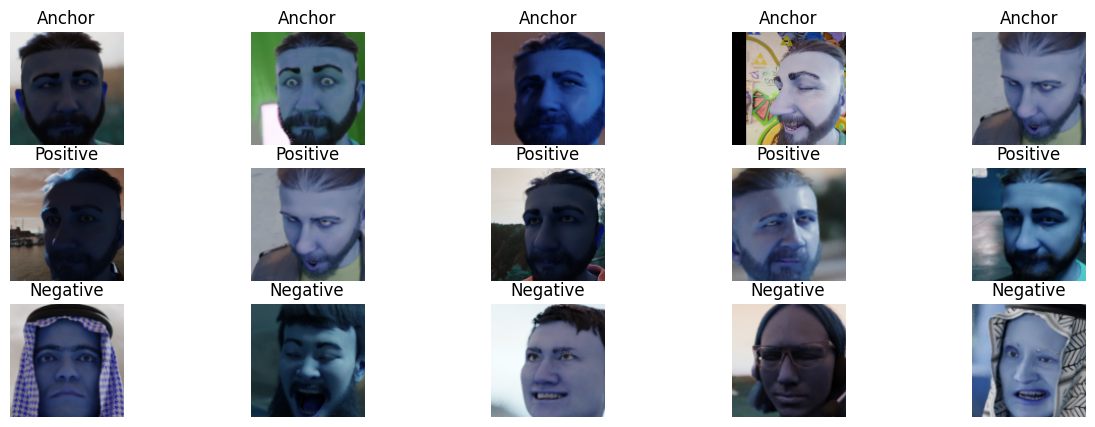

Number of anchor images:  (1000, 112, 112, 3)


In [83]:
# Visualize triplets
def visualize_triplets(anchor_images, positive_images, negative_images, num_triplets=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_triplets):
        plt.subplot(3, num_triplets, i + 1)
        plt.imshow(anchor_images[i])
        plt.title("Anchor")
        plt.axis('off')

        plt.subplot(3, num_triplets, i + 1 + num_triplets)
        plt.imshow(positive_images[i])
        plt.title("Positive")
        plt.axis('off')

        plt.subplot(3, num_triplets, i + 1 + 2 * num_triplets)
        plt.imshow(negative_images[i])
        plt.title("Negative")
        plt.axis('off')

    plt.show()

visualize_triplets(anchor_images, positive_images, negative_images)

# print number of images
print("Number of anchor images: ", anchor_images.shape)


In [84]:
# Compute distances
def compute_distances(embeddings, labels):
    distances = []
    for i in range(len(embeddings)):
        for j in range(i + 1, len(embeddings)):
            dist = np.linalg.norm(embeddings[i] - embeddings[j])
            same_class = labels[i] == labels[j]
            distances.append((dist, same_class))
    return distances

# Find best threshold
def find_best_threshold(distances):
    best_threshold = 0
    best_f1 = 0
    for threshold in np.arange(0, 2, 0.01):
        y_pred = [dist < threshold for dist, _ in distances]
        y_true = [same_class for _, same_class in distances]
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold

# Evaluate model
def evaluate_model(embedding_net, test_data, threshold):
    embeddings = []
    labels = []
    for img_path, label in zip(test_data['image_path'], test_data['identity']):
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (112, 112))
        img = img.astype('float32') / 255.0
        img = np.expand_dims(img, axis=0)
        embedding = embedding_net.predict(img)
        embeddings.append(embedding[0])
        labels.append(label)

    distances = compute_distances(embeddings, labels)

    y_true = [same_class for _, same_class in distances]
    y_pred = [dist < threshold for dist, _ in distances]

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return accuracy, precision, recall, f1

# Generate embeddings for the test set
embedding_net = siamese_net.layers[3]  # The embedding network is the fourth layer

# Generate embeddings for the test set
embeddings = []
labels = []
for img_path, label in zip(data_test['image_path'], data_test['identity']):
    img = cv2.imread(img_path)
    if img is None:
        continue
    img = cv2.resize(img, (112, 112))
    img = img.astype('float32') / 255.0
    img = np.expand_dims(img, axis=0)
    embedding = embedding_net.predict(img)
    embeddings.append(embedding[0])
    labels.append(label)

# Compute distances between all pairs of embeddings in the test set
distances = compute_distances(embeddings, labels)

# Find the best threshold
best_threshold = find_best_threshold(distances)
print(f"Best threshold: {best_threshold}")

# Evaluate the model
accuracy, precision, recall, f1 = evaluate_model(embedding_net, data_test, best_threshold)
print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 899ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━